In [1]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


2022-12-06 01:57:08.607612: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-06 01:57:08.725852: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-06 01:57:09.147460: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-06 01:57:09.147492: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

Num GPUs Available:  1


2022-12-06 01:57:09.669813: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 01:57:09.688504: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 01:57:09.688639: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
# LSTM with Dropout for sequence classification in the IMDB dataset
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

In [4]:
tf.__version__

'2.11.0'

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [6]:
np.__version__

'1.23.4'

In [7]:
data = pd.read_csv("OPV_data_SMILES.csv")
data = data[["PCE", "SMILES-D"]]
data.head(5)

,PCE,SMILES-D
0,1.36,CCCCCCc1c(C#CC2=C3CCC4N3[Zn@@]35n6c2ccc6C(=C2N...
1,1.24,CCCCCCc1c(C#CC2=C3CCC4N3[Zn@@]35n6c2ccc6C(=C2N...
2,3.16,CCCCCCc1c(/C=C/c2sc(c(c2CCCCCC)CCCCCC)C=C(C#N)...
3,2.10,CCCC[C@H](Cn1c2cc(ccc2c2c1c1c(c3c2n(C[C@H](CCC...
4,2.70,CCCC[C@H](Cn1c2cc(ccc2c2c1c1c(c3c2n(C[C@H](CCC...


## EDA

In [8]:
data_LSTM = data[['SMILES-D', 'PCE']]

In [9]:
maxPCE = data_LSTM['PCE'].max()
minPCE = data_LSTM['PCE'].min()
print(maxPCE, minPCE)

12.08 0.003


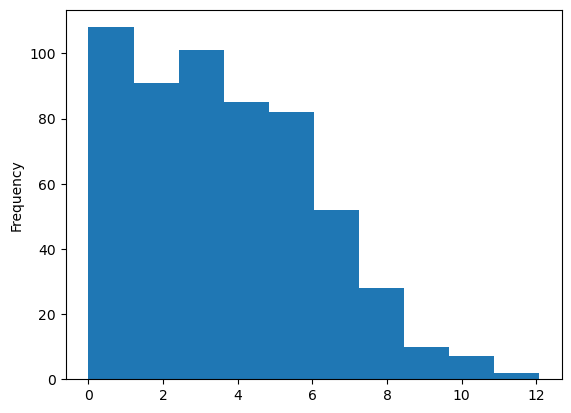

In [10]:
pce_val = data_LSTM['PCE']
pce_val.plot(kind='hist')
plt.show()

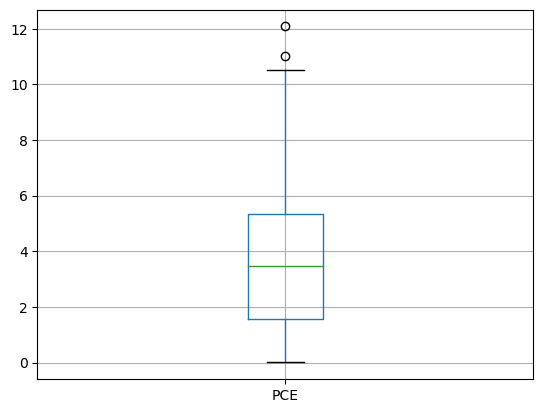

In [11]:
pce_val_bxplt = data_LSTM.boxplot(column = 'PCE')
pce_val_bxplt.plot()
plt.show()

## Create labels

In [12]:
def categorise(row):
    if row['PCE'] > 3.15:
        return 1
    elif row['PCE'] <= 3.15:
        return 0

In [13]:
data_LSTM['LABEL'] = data_LSTM.apply(lambda row: categorise(row), axis=1)
data_LSTM.head(5)

/tmp/ipykernel_180889/1828102457.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_LSTM['LABEL'] = data_LSTM.apply(lambda row: categorise(row), axis=1)


,SMILES-D,PCE,LABEL
0,CCCCCCc1c(C#CC2=C3CCC4N3[Zn@@]35n6c2ccc6C(=C2N...,1.36,0
1,CCCCCCc1c(C#CC2=C3CCC4N3[Zn@@]35n6c2ccc6C(=C2N...,1.24,0
2,CCCCCCc1c(/C=C/c2sc(c(c2CCCCCC)CCCCCC)C=C(C#N)...,3.16,1
3,CCCC[C@H](Cn1c2cc(ccc2c2c1c1c(c3c2n(C[C@H](CCC...,2.10,0
4,CCCC[C@H](Cn1c2cc(ccc2c2c1c1c(c3c2n(C[C@H](CCC...,2.70,0


In [14]:
data_LSTM.rename(columns = {'SMILES-D':'SMILES_D'}, inplace=True)

/tmp/ipykernel_180889/4024915585.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_LSTM.rename(columns = {'SMILES-D':'SMILES_D'}, inplace=True)


In [15]:
data_LSTM

,SMILES_D,PCE,LABEL
0,CCCCCCc1c(C#CC2=C3CCC4N3[Zn@@]35n6c2ccc6C(=C2N...,1.36,0
1,CCCCCCc1c(C#CC2=C3CCC4N3[Zn@@]35n6c2ccc6C(=C2N...,1.24,0
2,CCCCCCc1c(/C=C/c2sc(c(c2CCCCCC)CCCCCC)C=C(C#N)...,3.16,1
3,CCCC[C@H](Cn1c2cc(ccc2c2c1c1c(c3c2n(C[C@H](CCC...,2.10,0
4,CCCC[C@H](Cn1c2cc(ccc2c2c1c1c(c3c2n(C[C@H](CCC...,2.70,0
...,...,...,...
561,CCCC[C@H](CSc1ccc(s1)c1c2cc(sc2c(c2c1sc(c2)c1s...,4.50,1
562,CCCC[C@H](CSc1ccc(s1)c1c2cc(sc2c(c2c1sc(c2)c1s...,4.30,1
563,CCCC[C@H](Cc1ccc(s1)c1c2cc(sc2c(c2c1sc(c2)c1cc...,1.70,0
564,CCCC[C@H](Cc1ccc(s1)c1c2sc(cc2c(c2c1cc(s2)C1=[...,10.52,1


In [60]:
X_LSTM = data_LSTM['SMILES_D']
Y_LSTM = data_LSTM['LABEL']

In [72]:
vocab_size = 600#1000
tokenizer = tf.keras.preprocessing.text.Tokenizer(vocab_size, filters="", char_level=True)
tokenizer.fit_on_texts(X_LSTM)

In [73]:
# sequence padding
seqs = tokenizer.texts_to_sequences(X_LSTM)
padded_seqs = tf.keras.preprocessing.sequence.pad_sequences(seqs, padding='post')

In [74]:
x_train, x_test, y_train, y_test = (train_test_split(padded_seqs, Y_LSTM, test_size = 0.20))

In [75]:
x_train.shape

(452, 1373)

In [76]:
y_train.shape

(452,)

In [77]:
model = Sequential()
model.add(Embedding(input_dim=100, output_dim=128, mask_zero=True))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(48, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 128)         38400     
                                                                 
 lstm_12 (LSTM)              (None, None, 128)         131584    
                                                                 
 dropout_12 (Dropout)        (None, None, 128)         0         
                                                                 
 lstm_13 (LSTM)              (None, 48)                33984     
                                                                 
 dropout_13 (Dropout)        (None, 48)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 49        
                                                                 
Total params: 204,017
Trainable params: 204,017
Non-tr

In [78]:
optimizer = tf.keras.optimizers.Adam(lr=0.01)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [79]:
result = model.fit(x_train, y_train, validation_split=0.1, batch_size=100, epochs=250, verbose=1)
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/250
14/14 [==============================] - 6s 179ms/step - loss: 0.6918 - accuracy: 0.5419 - val_loss: 0.7040 - val_accuracy: 0.4348
Epoch 2/250
14/14 [==============================] - 1s 43ms/step - loss: 0.6837 - accuracy: 0.5542 - val_loss: 0.7205 - val_accuracy: 0.4348
Epoch 3/250
14/14 [==============================] - 0s 34ms/step - loss: 0.6821 - accuracy: 0.5542 - val_loss: 0.6909 - val_accuracy: 0.4565
Epoch 4/250
14/14 [==============================] - 0s 26ms/step - loss: 0.6733 - accuracy: 0.6084 - val_loss: 0.6954 - val_accuracy: 0.5435
Epoch 5/250
14/14 [==============================] - 0s 32ms/step - loss: 0.6555 - accuracy: 0.6182 - val_loss: 0.6735 - val_accuracy: 0.5652
Epoch 6/250
14/14 [==============================] - 0s 25ms/step - loss: 0.6500 - accuracy: 0.6281 - val_loss: 0.6747 - val_accuracy: 0.5870
Epoch 7/250
14/14 [==============================] - 0s 25ms/step - loss: 0.6420 - accuracy: 0.6305 - val_loss: 0.7446 - val_accuracy: 0.5652
Epoch

14/14 [==============================] - 0s 24ms/step - loss: 0.2875 - accuracy: 0.8621 - val_loss: 0.9698 - val_accuracy: 0.6087
Epoch 116/250
14/14 [==============================] - 0s 25ms/step - loss: 0.3265 - accuracy: 0.8522 - val_loss: 0.8346 - val_accuracy: 0.6957
Epoch 117/250
14/14 [==============================] - 0s 26ms/step - loss: 0.3105 - accuracy: 0.8670 - val_loss: 0.8136 - val_accuracy: 0.6304
Epoch 118/250
14/14 [==============================] - 0s 25ms/step - loss: 0.2886 - accuracy: 0.8916 - val_loss: 0.8170 - val_accuracy: 0.6522
Epoch 119/250
14/14 [==============================] - 0s 25ms/step - loss: 0.2420 - accuracy: 0.9064 - val_loss: 1.0761 - val_accuracy: 0.5870
Epoch 120/250
14/14 [==============================] - 0s 24ms/step - loss: 0.2666 - accuracy: 0.8916 - val_loss: 0.9703 - val_accuracy: 0.6304
Epoch 121/250
14/14 [==============================] - 0s 25ms/step - loss: 0.2443 - accuracy: 0.8916 - val_loss: 0.8764 - val_accuracy: 0.6522
Epoch 

Epoch 172/250
14/14 [==============================] - 0s 26ms/step - loss: 0.1071 - accuracy: 0.9409 - val_loss: 1.1848 - val_accuracy: 0.6957
Epoch 173/250
14/14 [==============================] - 0s 25ms/step - loss: 0.1118 - accuracy: 0.9483 - val_loss: 1.3363 - val_accuracy: 0.6522
Epoch 174/250
14/14 [==============================] - 0s 26ms/step - loss: 0.0867 - accuracy: 0.9581 - val_loss: 1.3113 - val_accuracy: 0.6304
Epoch 175/250
14/14 [==============================] - 0s 26ms/step - loss: 0.0864 - accuracy: 0.9581 - val_loss: 1.3343 - val_accuracy: 0.6304
Epoch 176/250
14/14 [==============================] - 0s 27ms/step - loss: 0.0832 - accuracy: 0.9631 - val_loss: 1.2355 - val_accuracy: 0.6739
Epoch 177/250
14/14 [==============================] - 0s 25ms/step - loss: 0.0865 - accuracy: 0.9581 - val_loss: 1.4888 - val_accuracy: 0.6522
Epoch 178/250
14/14 [==============================] - 0s 24ms/step - loss: 0.0854 - accuracy: 0.9631 - val_loss: 1.3302 - val_accuracy:

Epoch 229/250
14/14 [==============================] - 0s 25ms/step - loss: 0.0712 - accuracy: 0.9631 - val_loss: 1.4414 - val_accuracy: 0.6739
Epoch 230/250
14/14 [==============================] - 0s 26ms/step - loss: 0.0670 - accuracy: 0.9680 - val_loss: 1.4236 - val_accuracy: 0.6739
Epoch 231/250
14/14 [==============================] - 0s 26ms/step - loss: 0.0626 - accuracy: 0.9680 - val_loss: 1.4883 - val_accuracy: 0.6957
Epoch 232/250
14/14 [==============================] - 0s 26ms/step - loss: 0.0608 - accuracy: 0.9754 - val_loss: 1.3631 - val_accuracy: 0.7174
Epoch 233/250
14/14 [==============================] - 0s 26ms/step - loss: 0.0685 - accuracy: 0.9631 - val_loss: 1.4256 - val_accuracy: 0.6739
Epoch 234/250
14/14 [==============================] - 0s 26ms/step - loss: 0.0569 - accuracy: 0.9729 - val_loss: 1.3576 - val_accuracy: 0.6522
Epoch 235/250
14/14 [==============================] - 0s 25ms/step - loss: 0.0770 - accuracy: 0.9655 - val_loss: 1.4190 - val_accuracy:

In [1]:
#result.history

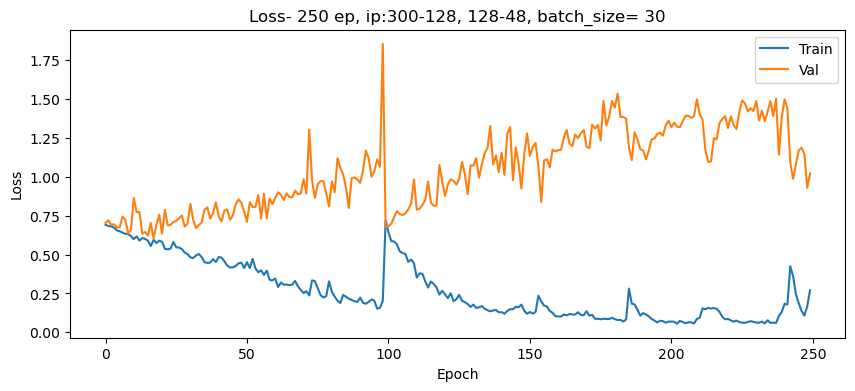

In [84]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(4)
plt.plot(result.history["loss"], label = "train")
plt.plot(result.history["val_loss"], label = "val")
plt.title("Loss- 250 ep, ip:300-128, 128-48, batch_size= 30")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['Train', 'Val'])
#plt.show()

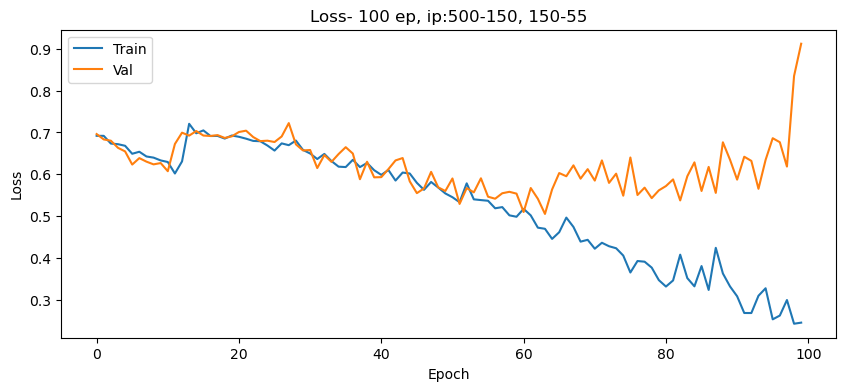

In [46]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(4)
plt.plot(result.history["loss"], label = "train")
plt.plot(result.history["val_loss"], label = "val")
plt.title("Loss- 100 ep, ip:500-150, 150-55, batch_size= 10")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['Train', 'Val'])
#plt.show()

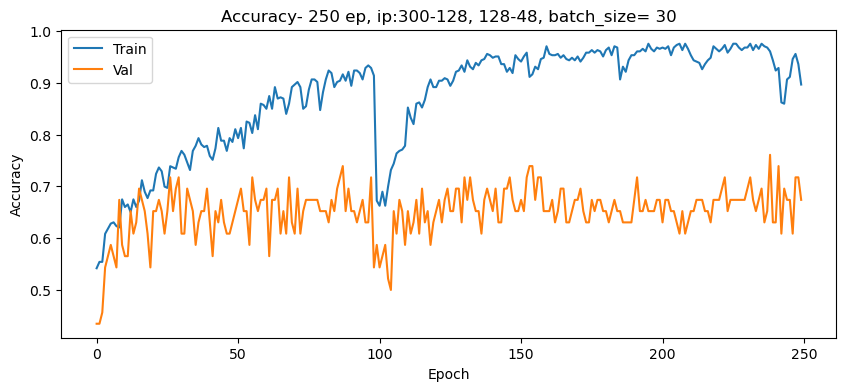

In [83]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(4)
plt.plot(result.history["accuracy"], label = "train")
plt.plot(result.history["val_accuracy"], label = "val")
plt.title("Accuracy- 250 ep, ip:300-128, 128-48, batch_size= 30")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['Train', 'Val'])

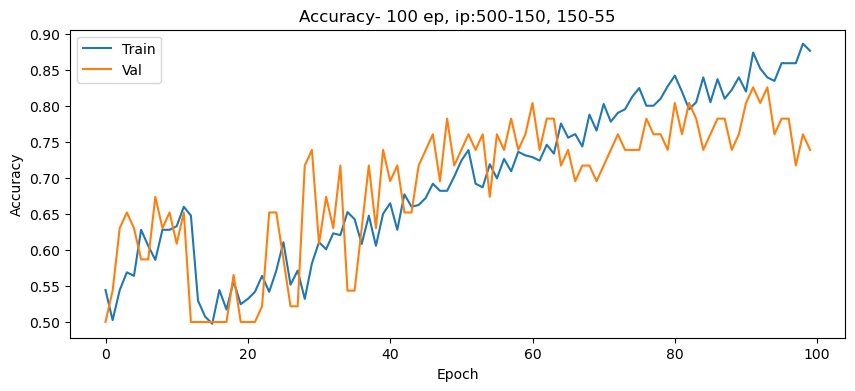

In [48]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(4)
plt.plot(result.history["accuracy"], label = "train")
plt.plot(result.history["val_accuracy"], label = "val")
plt.title("Accuracy- 100 ep, ip:500-150, 150-55, batch_size= 10")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['Train', 'Val'])

In [49]:
scores = model.evaluate(x_test, y_test)

4/4 [==============================] - 0s 11ms/step - loss: 1.2516 - accuracy: 0.6667
